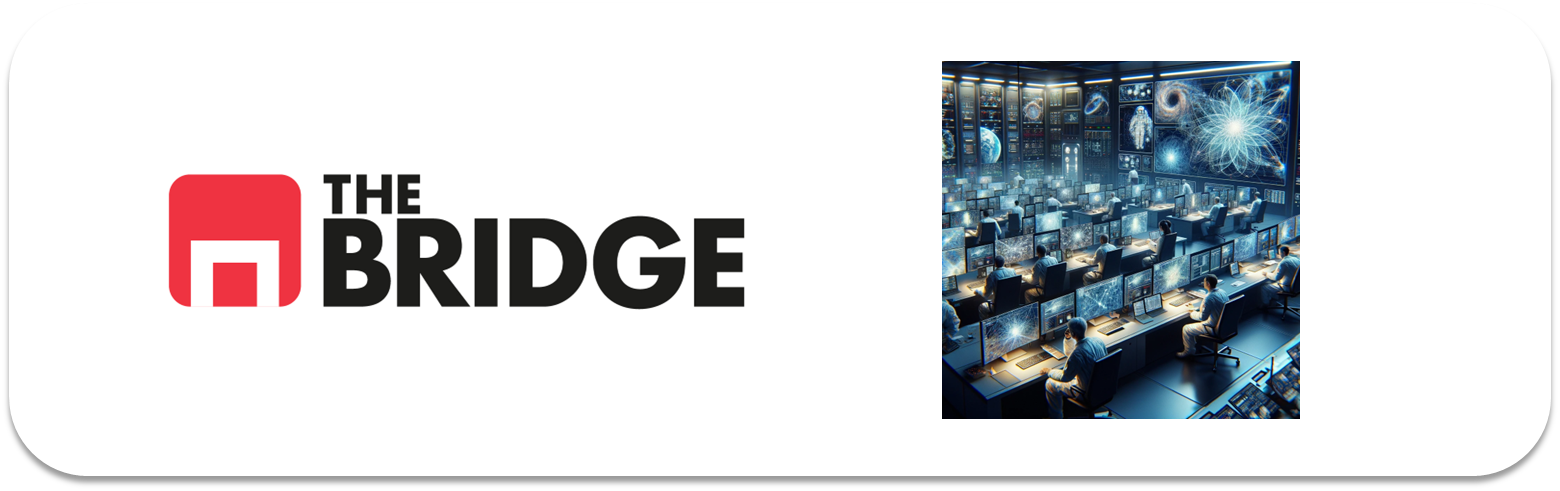

## PRACTICA OBLIGATORIA: **Transfer Learning y Fine Tuning**

* La práctica obligatoria de esta unidad consiste en un repetir el ejercicio de construcción de un modelo de clasificación de paisajes pero usando un modelo preentrenado. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns


from skimage.io import imread
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

### Objetivo del ejercicio

Comparar una red convolucional hecha ad-hoc frente a los modelos preentrenados y ajustados con fine tuning y transfer learning. Para ello emplea el dataset de paisajes del conjunto de ejercicios de la unidad anterior.


### Se pide

1. Preparar los datos del modelo y las funciones de visualización, copia para ello todo lo que necesites de las soluciones del ejercicio de clasificación de paisajes de la unidad anterior.

2. Escoger entre uno de los modelos VGG-19, InceptionV3 y MobileNetV2 (todos en https://keras.io/api/applications/) (Se aconseja este último si no tenemos un ordenador muy potente). Si no te haces con estos puedes recurrir a la ResNetV50.

4. Hacer un transfer-learning con una cabeza de como mucho 2 capas densas ocultas y una de salida. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

5. Hacer un fine-tuning con la misma cabeza diseñada en el punto anterior. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

6. Comparar los resultados con los obtenidos con la red convolucional del ejercicio mencionado.

EXTRA:
- Repetir el transfer learning empleando aumentado de imágenes.



In [2]:
ROOT_PATH = './data/'
TRAIN_PATH = ROOT_PATH + "seg_train/"
TEST_PATH = ROOT_PATH + "seg_test/"

In [3]:
def read_data(directorio, reshape_dim = (75,75)):
    X = [] 
    y = []
    for folder in os.listdir(directorio):
        print(folder)
        if os.path.isdir('/'.join([directorio, folder])):
            for file in os.listdir('/'.join([directorio, folder])):

                image = imread('/'.join([directorio, folder, file]))
                image = cv2.resize(image, reshape_dim) # Redimensionamos las imágenes a 32x32

                X.append(image)
                y.append(folder)

    return np.array(X),np.array(y)

def show_images_batch(paisajes, names = [], n_cols = 5, size_scale = 2):
    n_rows = ((len(paisajes) - 1) // n_cols + 1)
    plt.figure(figsize=(n_cols * size_scale, n_rows * 1.1*size_scale))
    for index, paisaje in enumerate(paisajes):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(paisaje, cmap = "Greys")
        plt.axis("off")
        if len(names):
            plt.title(names[index])

In [4]:
X_train,y_train = read_data('./data/seg_train/seg_train/')
X_test, y_test = read_data('./data/seg_test/seg_test/')

forest
buildings
glacier
street
mountain
sea
forest
buildings
glacier
street
mountain
sea


In [5]:
print('X train shape: ', X_train.shape)
print('Y train shape: ', y_train.shape)

X train shape:  (14034, 75, 75, 3)
Y train shape:  (14034,)


In [6]:
print('X test shape: ', X_test.shape)
print('Y test shape: ', y_test.shape)

X test shape:  (3000, 75, 75, 3)
Y test shape:  (3000,)


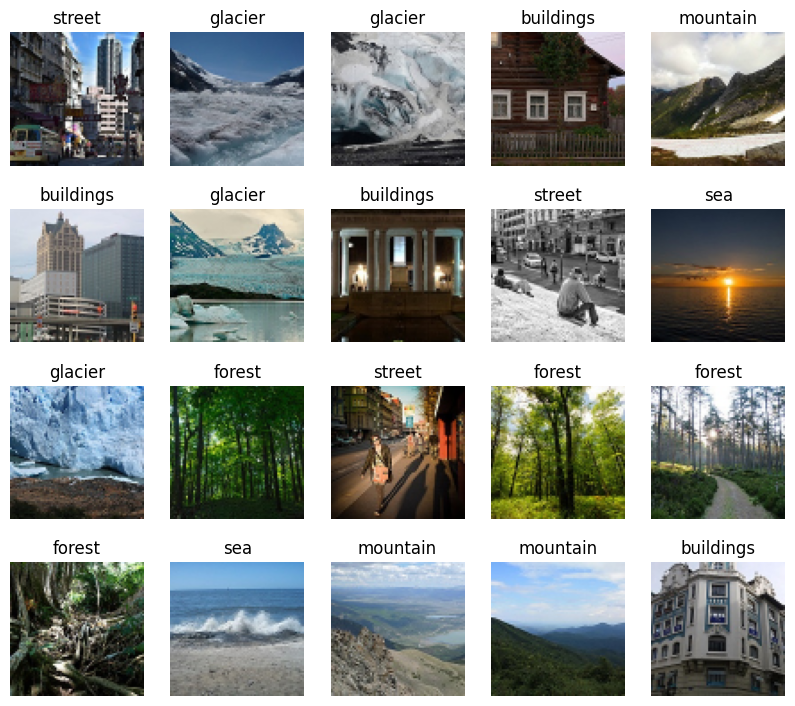

In [7]:
indices = np.random.randint(0,len(X_train),20)
show_images_batch(X_train[indices], names = y_train[indices], n_cols = 5)

In [8]:
targets = pd.Series(y_train)
targets.value_counts(True)

mountain     0.178994
glacier      0.171298
street       0.169731
sea          0.162035
forest       0.161821
buildings    0.156121
Name: proportion, dtype: float64

In [9]:
X_train = X_train/255
X_test = X_test/255

### He escogido el Inception

## Transfer Learning

In [10]:
from keras.applications import InceptionV3

In [11]:
base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=(75, 75, 3))

for layer in base_model.layers:
    layer.trainable = False

def prepare_model(base_model = base_model): 
    x = keras.layers.Flatten()(base_model.output)
    x = keras.layers.Dense(2048, activation='relu')(x)
    x = keras.layers.Dropout(rate = 0.25)(x)
    x = keras.layers.Dense(6, activation='softmax')(x)
    model = keras.Model(base_model.input, x)
    model.compile(optimizer = "adam", loss = 'sparse_categorical_crossentropy', metrics = ['acc']) # sparse -> y es un array de escalares pero hay varias categorias, y un array de vectores
    return model

In [12]:
model = prepare_model()

In [13]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 75, 75, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 37, 37,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 37, 37,    │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 37, 37,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 35, 35,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 35, 35,    │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 35, 35,    │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 35, 35,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 17, 17,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 17, 17,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 17, 17,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 17, 17,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 15, 15,    │    138,240 │ activation_3[0][… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15, 15,    │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 15, 15,    │          0 │ batch_normalizat

 Total params: 26,011,430 (99.23 MB)

 Trainable params: 4,208,646 (16.05 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [14]:
targets = pd.Series(y_train)

In [15]:
mapa = {tipo:indice for indice,tipo in enumerate(targets.unique())} # Rehusando la serie que creamos para ver la distribución del target
mapa

{'forest': 0,
 'buildings': 1,
 'glacier': 2,
 'street': 3,
 'mountain': 4,
 'sea': 5}

In [16]:
y_train_num = np.array([mapa[y] for y in y_train])
y_test_num = np.array([mapa[y] for y in y_test])

In [17]:
X_train, y_train_num = shuffle(X_train, y_train_num)

In [18]:
history = model.fit(X_train,
                    y_train_num,
                    validation_split = 0.2,
                    epochs = 25,
                    batch_size = 128, callbacks= [keras.callbacks.EarlyStopping(patience = 10, restore_best_weights= True)]) 

Epoch 1/25
88/88 ━━━━━━━━━━━━━━━━━━━━ 27s 279ms/step - acc: 0.6170 - loss: 1.1532 - val_acc: 0.7595 - val_loss: 0.6382
Epoch 2/25
88/88 ━━━━━━━━━━━━━━━━━━━━ 1012s 12s/step - acc: 0.8220 - loss: 0.4899 - val_acc: 0.7627 - val_loss: 0.6331
Epoch 3/25
88/88 ━━━━━━━━━━━━━━━━━━━━ 27s 309ms/step - acc: 0.8678 - loss: 0.3643 - val_acc: 0.7773 - val_loss: 0.6099
Epoch 4/25
88/88 ━━━━━━━━━━━━━━━━━━━━ 27s 306ms/step - acc: 0.9181 - loss: 0.2507 - val_acc: 0.7738 - val_loss: 0.6871
Epoch 5/25
88/88 ━━━━━━━━━━━━━━━━━━━━ 1063s 12s/step - acc: 0.9490 - loss: 0.1712 - val_acc: 0.7855 - val_loss: 0.6727
Epoch 6/25
88/88 ━━━━━━━━━━━━━━━━━━━━ 27s 309ms/step - acc: 0.9731 - loss: 0.1103 - val_acc: 0.7830 - val_loss: 0.7068
Epoch 7/25
88/88 ━━━━━━━━━━━━━━━━━━━━ 28s 313ms/step - acc: 0.9899 - loss: 0.0611 - val_acc: 0.7788 - val_loss: 0.7710
Epoch 8/25
88/88 ━━━━━━━━━━━━━━━━━━━━ 28s 321ms/step - acc: 0.9951 - loss: 0.0404 - val_acc: 0.7781 - val_loss: 0.8155
Epoch 9/25
88/88 ━━━━━━━━━━━━━━━━━━━━ 29s 331ms/

In [19]:
history_df = pd.DataFrame(history.history)
history_df

,acc,loss,val_acc,val_loss
0,0.703661,0.847429,0.759530,0.638195
1,0.820255,0.490238,0.762736,0.633081
2,0.865325,0.369258,0.777342,0.609894
3,0.908791,0.263498,0.773780,0.687090
4,0.945667,0.176816,0.785536,0.672686
5,0.972833,0.110112,0.783042,0.706840
6,0.987886,0.062506,0.778767,0.770998
7,0.994745,0.040660,0.778055,0.815529
8,0.998219,0.024350,0.779480,0.846568
9,0.998753,0.017594,0.779836,0.866669


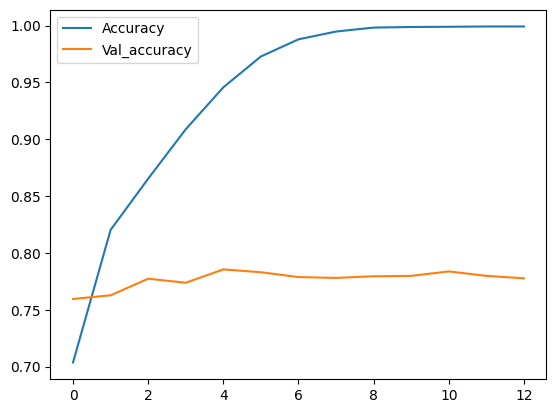

In [20]:
plt.plot(history_df['acc'], label = 'Accuracy')
plt.plot(history_df['val_acc'], label = 'Val_accuracy')

plt.legend();

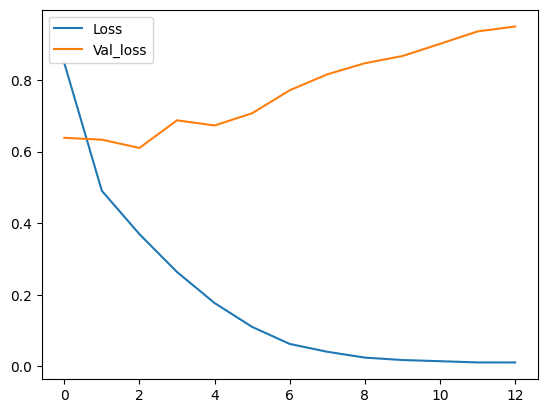

In [21]:
plt.plot(history_df['loss'], label = 'Loss')
plt.plot(history_df['val_loss'], label = 'Val_loss')

plt.legend();

In [22]:
model.evaluate(X_test,y_test_num)

94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 81ms/step - acc: 0.8453 - loss: 0.4526


[0.6234294772148132, 0.7763333320617676]

In [23]:
y_pred = [np.argmax(prediction) for prediction in model.predict(X_test)]

94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step


In [24]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
inverse_map = {valor:clave for clave,valor in mapa.items()}
y_test_labels = [inverse_map[y] for y in y_test_num]
y_pred_labels = [inverse_map[y] for y in y_pred]
print(classification_report(y_test_labels, y_pred_labels))

              precision    recall  f1-score   support

   buildings       0.88      0.77      0.82       437
      forest       0.93      0.95      0.94       474
     glacier       0.66      0.72      0.69       553
    mountain       0.66      0.69      0.68       525
         sea       0.78      0.70      0.74       510
      street       0.81      0.84      0.82       501

    accuracy                           0.78      3000
   macro avg       0.79      0.78      0.78      3000
weighted avg       0.78      0.78      0.78      3000



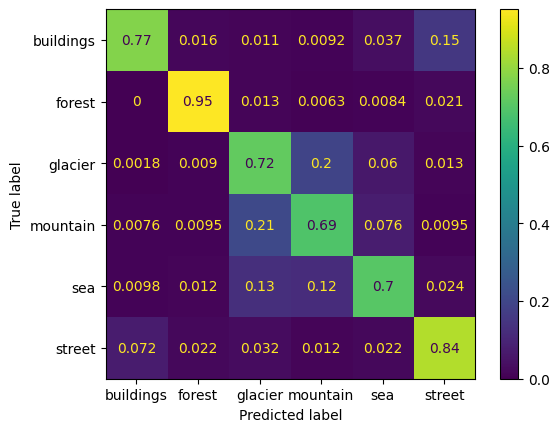

In [25]:
ConfusionMatrixDisplay.from_predictions(y_test_labels, y_pred_labels, normalize="true")

## Fine-tuning

In [26]:
base_model = InceptionV3(include_top=False, weights=None, input_shape=(75, 75, 3))

def prepare_model(base_model = base_model):
    x = keras.layers.Flatten()(base_model.output)
    x = keras.layers.Dense(2048, activation='relu')(x)
    x = keras.layers.Dropout(rate = 0.25)(x)
    x = keras.layers.Dense(6, activation='softmax')(x)
    
    model_2 = keras.Model(base_model.input, x)
    model_2.compile(optimizer = "adam", loss = 'sparse_categorical_crossentropy', metrics = ['acc'])
    return model_2

In [27]:
model_2 = prepare_model()

In [28]:
#model_2.summary()

In [29]:
history = model_2.fit(X_train,
                    y_train_num,
                    validation_split = 0.2,
                    epochs = 25,
                    batch_size = 128, callbacks= [keras.callbacks.EarlyStopping(patience = 10, restore_best_weights= True)]) 

Epoch 1/25
88/88 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - acc: 0.3670 - loss: 2.0418 - val_acc: 0.1564 - val_loss: 2.0327
Epoch 2/25
88/88 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - acc: 0.6505 - loss: 0.9596 - val_acc: 0.2024 - val_loss: 2.7120
Epoch 3/25
88/88 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - acc: 0.7228 - loss: 0.7774 - val_acc: 0.1856 - val_loss: 2.8663
Epoch 4/25
88/88 ━━━━━━━━━━━━━━━━━━━━ 160s 2s/step - acc: 0.7735 - loss: 0.6366 - val_acc: 0.3545 - val_loss: 2.9814
Epoch 5/25
88/88 ━━━━━━━━━━━━━━━━━━━━ 166s 2s/step - acc: 0.8019 - loss: 0.5674 - val_acc: 0.5932 - val_loss: 1.2569
Epoch 6/25
88/88 ━━━━━━━━━━━━━━━━━━━━ 170s 2s/step - acc: 0.8247 - loss: 0.5053 - val_acc: 0.6234 - val_loss: 1.4235
Epoch 7/25
88/88 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - acc: 0.8535 - loss: 0.4160 - val_acc: 0.6861 - val_loss: 1.0068
Epoch 8/25
88/88 ━━━━━━━━━━━━━━━━━━━━ 181s 2s/step - acc: 0.8586 - loss: 0.4210 - val_acc: 0.1632 - val_loss: 100984.7344
Epoch 9/25
88/88 ━━━━━━━━━━━━━━━━━━━━ 176s 2s/step - acc: 0

In [30]:
history_df = pd.DataFrame(history.history)
history_df

,acc,loss,val_acc,val_loss
0,0.484368,1.443969,0.156395,2.032713
1,0.658591,0.931587,0.202351,2.711963
2,0.723791,0.760501,0.185607,2.866333
3,0.775007,0.643200,0.354471,2.981397
4,0.801639,0.565386,0.593160,1.256884
5,0.823550,0.511231,0.623441,1.423524
6,0.848401,0.437752,0.686142,1.006807
7,0.848936,0.460000,0.163164,100984.734375
8,0.760132,0.734975,0.650873,1.471392
9,0.793355,0.626571,0.578910,1.925606


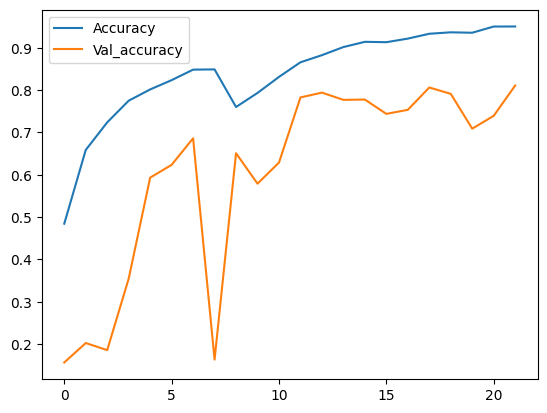

In [31]:
plt.plot(history_df['acc'], label = 'Accuracy')
plt.plot(history_df['val_acc'], label = 'Val_accuracy')

plt.legend();

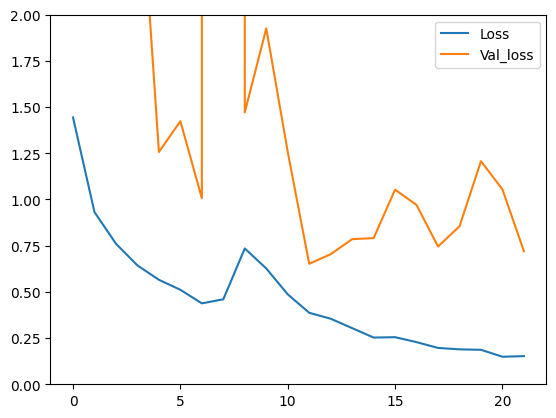

In [43]:
plt.plot(history_df['loss'], label = 'Loss')
plt.plot(history_df['val_loss'], label = 'Val_loss')
plt.ylim(0,2)
plt.legend();

In [37]:
model_2.evaluate(X_test,y_test_num)

94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - acc: 0.7774 - loss: 0.7223


[0.6916742920875549, 0.777999997138977]

In [38]:
y_pred = [np.argmax(prediction) for prediction in model_2.predict(X_test)]

94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step


In [39]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
inverse_map = {valor:clave for clave,valor in mapa.items()}
y_test_labels = [inverse_map[y] for y in y_test_num]
y_pred_labels = [inverse_map[y] for y in y_pred]
print(classification_report(y_test_labels, y_pred_labels))

              precision    recall  f1-score   support

   buildings       0.79      0.78      0.79       437
      forest       0.99      0.81      0.89       474
     glacier       0.84      0.65      0.73       553
    mountain       0.86      0.65      0.74       525
         sea       0.61      0.94      0.74       510
      street       0.75      0.86      0.80       501

    accuracy                           0.78      3000
   macro avg       0.81      0.78      0.78      3000
weighted avg       0.81      0.78      0.78      3000



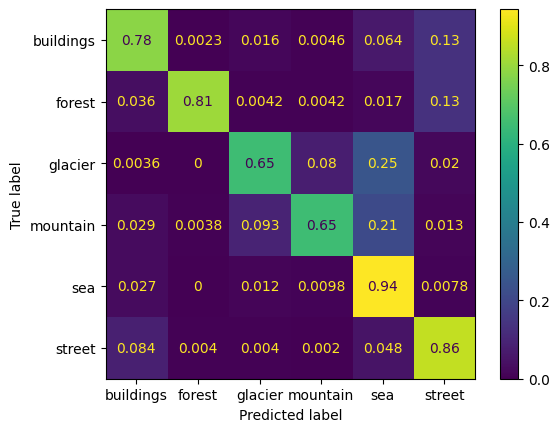

In [40]:
ConfusionMatrixDisplay.from_predictions(y_test_labels, y_pred_labels, normalize="true")